In [1]:
#pip install h5py nibabel pandas glob2 regex
import os
import sys
import numpy as np
import nibabel as nib
import h5py
import time
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
import scipy
import torch
import torch.nn as nn
os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work
import scipy.io as sio

In [ ]:
Vol = 5

with h5py.File(f'AllMaps_vanilla_Vol{Vol}.mat', 'r') as f:
    print(list(f.keys()))  # Zeigt dir die verfügbaren Variablennamen
    data = f['AllMaps']  # Beispiel: lade Dataset
    metabos = data['Metabos']
    Title = metabos['Title'][:]
    title_refs = metabos['Title']
    MetabMaps = metabos['Normal'][:]
    #print(list(data.keys()))
    #print(list(metabos.keys()))
    titles = []
    for ref in title_refs[0]:  # assuming shape (1, N)
        dset = f[ref]
        title = dset[:].tobytes().decode('utf-16-le')  # ← das ist der Trick
        titles.append(title)

with h5py.File(f'AllMaps_Hauke_Vol{Vol}.mat', 'r') as f:
    print(list(f.keys()))  # Zeigt dir die verfügbaren Variablennamen
    data = f['AllMaps']  # Beispiel: lade Dataset
    metabos = data['Metabos']
    Title = metabos['Title'][:]
    title_refs = metabos['Title']
    MetabMaps_Hauke = metabos['Normal'][:]
    #print(list(data.keys()))
    #print(list(metabos.keys()))
    titles = []
    for ref in title_refs[0]:  # assuming shape (1, N)
        dset = f[ref]
        title = dset[:].tobytes().decode('utf-16-le')  # ← das ist der Trick
        titles.append(title)
    #print(titles)

with h5py.File(f'AllMaps_Hauke_Vol{Vol}_3.mat', 'r') as f:
#with h5py.File(f'AllMaps_Hauke_Vol{Vol}_2.mat', 'r') as f:
    print(list(f.keys()))  # Zeigt dir die verfügbaren Variablennamen
    data = f['AllMaps']  # Beispiel: lade Dataset
    metabos = data['Metabos']
    Title = metabos['Title'][:]
    title_refs = metabos['Title']
    MetabMaps_Paul = metabos['Normal'][:]
    #print(list(data.keys()))
    #print(list(metabos.keys()))
    titles = []
    for ref in title_refs[0]:  # assuming shape (1, N)
        dset = f[ref]
        title = dset[:].tobytes().decode('utf-16-le')  # ← das ist der Trick
        titles.append(title)

['#refs#', 'AllMaps', 'Par', 'WaterRefState', 'out_dir', 'tmp_dir']
['#refs#', 'AllMaps', 'Par', 'WaterRefState', 'out_dir', 'tmp_dir']
['#refs#', 'AllMaps', 'Par', 'WaterRefState', 'out_dir', 'tmp_dir']


/tmp/ipykernel_3406192/35745876.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


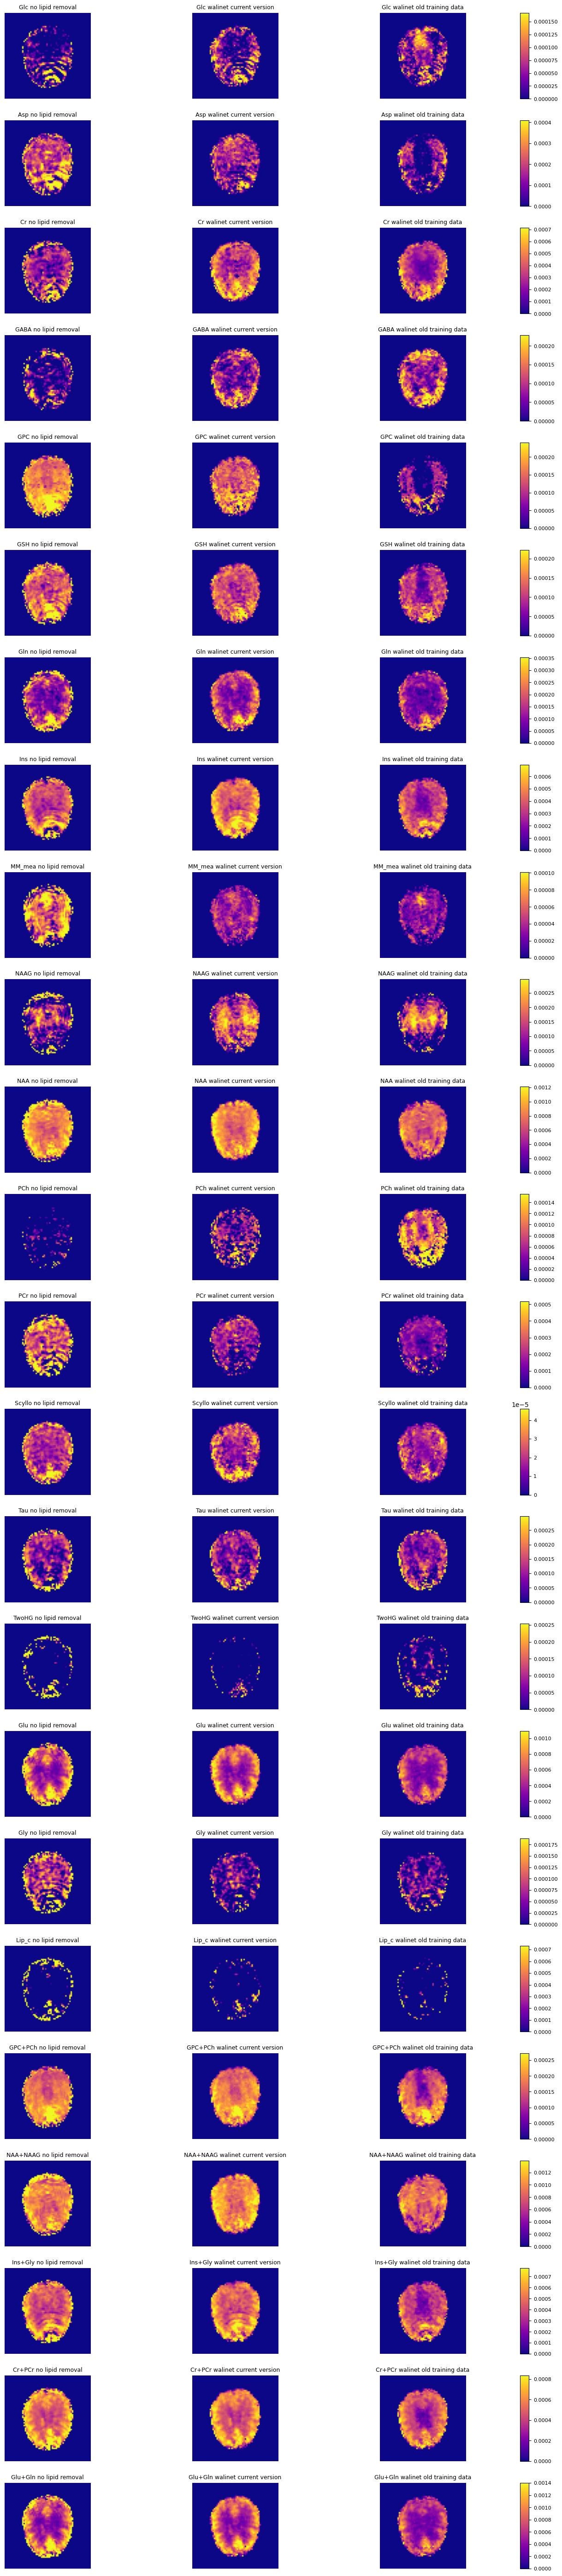

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming these are your 3 sets of maps:
maps_vanilla       = MetabMaps[:, 17, :, :]
maps_walinet_paul  = MetabMaps_Paul[:, 17, :, :]
maps_walinet_hauke = MetabMaps_Hauke[:, 17, :, :]  # adjust source as needed

# Compute common vmin/vmax from the 1st to 99th percentile of all data
combined = np.concatenate([
    maps_vanilla.flatten(),
    maps_walinet_paul.flatten(),
    maps_walinet_hauke.flatten()
])
finite = combined[np.isfinite(combined)]
vmin, vmax = np.nanpercentile(finite, [1, 99])

# Prepare the figure with 3 columns
# Prepare the figure with 3 columns
# n = len(titles)
# fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(15, n * 3))

# for i, title in enumerate(titles):
#     # Vanilla
#     im = axes[i, 0].imshow(maps_vanilla[i], cmap='plasma', vmin=vmin, vmax=vmax, origin='lower')
#     axes[i, 0].axis('off')
#     axes[i, 0].set_title(f"{title} no lipid removal", fontsize=9)
#     fig.colorbar(im, ax=axes[i, 0], fraction=0.046, pad=0.04)

#     # Walinet-Hauke
#     im = axes[i, 1].imshow(maps_walinet_hauke[i], cmap='plasma', vmin=vmin, vmax=vmax, origin='lower')
#     axes[i, 1].axis('off')
#     axes[i, 1].set_title(f"{title} walinet current version", fontsize=9)
#     fig.colorbar(im, ax=axes[i, 1], fraction=0.046, pad=0.04)

#     # Walinet-Paul
#     im = axes[i, 2].imshow(maps_walinet_paul[i], cmap='plasma', vmin=vmin, vmax=vmax, origin='lower')
#     axes[i, 2].axis('off')
#     axes[i, 2].set_title(f"{title} walinet old training data", fontsize=9)
#     fig.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)

# plt.tight_layout()
# plt.show()

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Percentile clipping values

# Your data and titles arrays:
# titles = ["Metabolite1", "Metabolite2", ...]
# maps_vanilla      = [array1, array2, ...]
# maps_walinet_hauke = [array1, array2, ...]
# maps_walinet_paul  = [array1, array2, ...]

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # ← add this

low_pct, high_pct = 2, 98            # percentile clip
n = len(titles)

# create figure and GridSpec with a narrow 4th column for colorbars
fig = plt.figure(figsize=(16, n * 3))
gs  = gridspec.GridSpec(
        nrows=n, ncols=4,
        width_ratios=[1, 1, 1, 0.05],   # last column for c-bars
        wspace=0.05, hspace=0.25
      )

for i, title in enumerate(titles):
    row_maps = [maps_vanilla[i],
                maps_walinet_hauke[i],
                maps_walinet_paul[i]]

    # shared percentile window for this row (ignore NaNs)
    valid_vals = np.concatenate([m[~np.isnan(m)] for m in row_maps])
    vmin, vmax = np.percentile(valid_vals, (low_pct, high_pct))

    for j, (m, lbl) in enumerate(zip(
            row_maps,
            ("no lipid removal",
             "walinet current version",
             "walinet averaged projection OP"))):

        ax  = fig.add_subplot(gs[i, j])
        # turn NaNs into zeros
        arr = np.nan_to_num(m, nan=0.0)
        im  = ax.imshow(arr, cmap='plasma', origin='lower',
                        vmin=vmin, vmax=vmax)
        ax.set_title(f"{title} {lbl}", fontsize=9)
        ax.axis('off')

    # shared colorbar for the row
    cax = fig.add_subplot(gs[i, 3])
    fig.colorbar(im, cax=cax)
    cax.tick_params(labelsize=8)


plt.tight_layout()
plt.show()